Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [232]:
import numpy as np
from icecream import ic
from collections import namedtuple
import matplotlib.pyplot as plt

In [233]:
NUM_KNAPSACKS = 3
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

In [234]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [235]:
CONSTRAINTS

array([[135,  99],
       [267, 103],
       [254, 191]], dtype=int32)

## Solver


In [ ]:
KnapsackParams = namedtuple("KnapsackParams", ["n_knapsacks", "n_items", "n_dimensions" , "vals" ,"weights", "constraints"])

# Perform a random modification to the current solution (add/remove/swap items between knapsacks)
def update_solution(solution: np.ndarray, params):
    id_knapsack = np.random.randint(0, params.n_knapsacks)
    item = np.random.randint(0, params.n_items)

    if solution[id_knapsack, item]:
        solution[id_knapsack, item] = False 
    elif not np.any(solution[:, item], axis=0):
        solution[id_knapsack, item] = True

    knapsack1, knapsack2 = np.random.choice(params.n_knapsacks, size= 2, replace=False)
    item1 = np.random.randint(0, params.n_items) 
    item2 = np.random.randint(0, params.n_items) 

    solution[knapsack1, item1], solution[knapsack2, item2] = solution[knapsack2, item2], solution[knapsack1, item1]

    return solution


# Compute the value of the solution. Returns -100 if the solution is infeasible
def fit(solution: np.ndarray, params) -> int:
    if not is_feasible(solution, params):
        return -100
    return sum(params.vals[np.any(solution, axis= 0)])

# Check whether the solution satisfies the problem constraints (no duplicate items and weights below the limit)
def is_feasible(solution: np.ndarray, params) -> bool:
    if not np.all(solution.sum(axis=0) <=1 ):
        return False
    for i in range(params.n_knapsacks):
        if np.any(params.weights[solution[i].sum(axis = 0)] > params.constraints[i]):
            return False
    return True

# Iteratively modify the solution until it becomes feasible
def to_feasible(solution: np.ndarray, params) -> np.ndarray:

    while not is_feasible(solution, params):
        knapsack = np.random.randint(0, params.n_knapsacks)
        items_knapsack = np.where(solution[knapsack])[0]
        if len(items_knapsack) == 0:
            continue
        item_to_delete = np.random.choice(items_knapsack)
        solution[knapsack, item_to_delete] = False
    return solution


    
# Simulated Annealing algorithm for searching the optimal solution
def simulated_annealing_solver(*, initial_solution = None, max_it: int = 1000, temperature: float = 100.0, params) -> tuple[np.ndarray, int]:
    # Initializing solution
    if initial_solution is None:
        solution = np.zeros((params.n_knapsacks, params.n_items), dtype=bool)
    else: 
        solution = initial_solution

    solution = to_feasible(solution, params)

    best_solution = solution.copy()
    best_fit = fit(best_solution, params)

    current_solution = solution.copy()
    current_fit = fit(current_solution, params) #10

    # Value history for plotting
    best_fit_history = [0] * (max_it + 1)
    current_fit_history = [0] * (max_it + 1)

    best_fit_history[0] = best_fit
    current_fit_history[0] = current_fit


    # Main loop of the Simulated Annealing algorithm
    for i in range(max_it):
        new_solution = update_solution(current_solution.copy(), params)
        new_fit = fit(new_solution, params)

        delta = new_fit - current_fit

        if delta > 0 or np.random.rand() < np.exp(delta / temperature):
            if(new_fit > 0):
                current_solution = new_solution.copy()
                current_fit = new_fit
                if new_fit > best_fit:
                    best_solution = new_solution.copy()
                    best_fit = new_fit

        if(i%100 == 0):
            temperature *= 0.99  # Gradual cooling every 100 iterations
        
        best_fit_history[i+1] = best_fit
        current_fit_history[i+1] = current_fit

    return best_solution, best_fit, best_fit_history, current_fit_history

    
def plot_history(best_fit_history, current_fit_history) -> None:
    plt.loglog(best_fit_history, label='Best Fitness')
    plt.loglog(current_fit_history, label='Current Fitness')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.title('Knapsack Problem Fitness Over Iterations')
    plt.legend()
    plt.show()

    




## TEST PROBLEMS

In [237]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

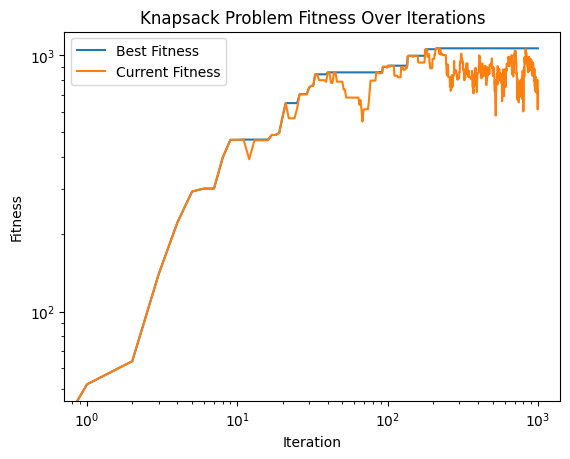

Final best fit: 1065
Final best solution: [[ True False False False False  True False False False  True  True False
  False False  True  True  True False False False]
 [False False  True  True  True False False  True  True False False  True
  False False False False False False  True False]
 [False  True False False False False  True False False False False False
   True  True False False False  True False  True]]


In [238]:
params = KnapsackParams(
    n_knapsacks=NUM_KNAPSACKS,
    n_items=NUM_ITEMS,
    n_dimensions=NUM_DIMENSIONS,
    vals=VALUES,
    weights=WEIGHTS,
    constraints=CONSTRAINTS
)

best_solution, best_fit, best_fit_history, current_fit_history = simulated_annealing_solver(params=params, max_it=1000, temperature=200)
plot_history(best_fit_history, current_fit_history)
print(f"Final best fit: {best_fit}")
print(f"Final best solution: {best_solution}")


In [239]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

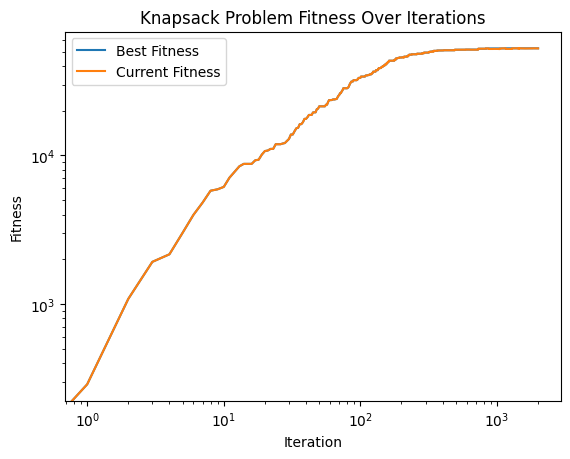

Final best fit: 52620
Final best solution: [[False False False False False False False False False False False False
  False False False False False False False False  True False False  True
  False False False False False False False False False False False False
  False False False False False False  True False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False  True False False False False False False False False False False
  False  True False False]
 [False False False False False False  True False  True False False False
  False  True False False False  True False False False False False False
   True False False  True False False False False False False False False
  False False False False False False False False False False False False
  False False False  True False False Fals

In [240]:
params = KnapsackParams(
    n_knapsacks=NUM_KNAPSACKS,
    n_items=NUM_ITEMS,
    n_dimensions=NUM_DIMENSIONS,
    vals=VALUES,
    weights=WEIGHTS,
    constraints=CONSTRAINTS
)

best_solution, best_fit, best_fit_history, current_fit_history = simulated_annealing_solver(params=params, max_it=2000, temperature= 200)
plot_history(best_fit_history, current_fit_history)
print(f"Final best fit: {best_fit}")
print(f"Final best solution: {best_solution}")

In [241]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

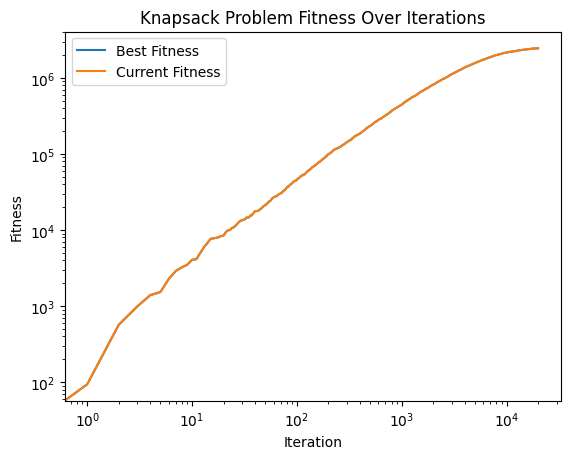

Final best fit: 2447713
Final best solution: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [242]:
params = KnapsackParams(
    n_knapsacks=NUM_KNAPSACKS,
    n_items=NUM_ITEMS,
    n_dimensions=NUM_DIMENSIONS,
    vals=VALUES,
    weights=WEIGHTS,
    constraints=CONSTRAINTS
)

best_solution, best_fit, best_fit_history, current_fit_history = simulated_annealing_solver(params=params, max_it=20000, temperature=500)
plot_history(best_fit_history, current_fit_history)
print(f"Final best fit: {best_fit}")
print(f"Final best solution: {best_solution}")
